In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd '/content/drive/My Drive/Fall 2020/1006 Capstone/NYU_Team18_Accern_Capstone_Fall2020/'

/content/drive/My Drive/Fall 2020/1006 Capstone/NYU_Team18_Accern_Capstone_Fall2020


In [3]:
!pip install transformers
!pip install pytorch-lightning==1.0.8

In [4]:
import numpy as np
import pandas as pd
import torch

from read_data import *
from FinSentiment import *

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


### Train on Correct

In [5]:
pretrained_bert_name = 'distilbert-base-cased'
incorrect_type = 'correct'
company_embedding_method = 'sum_output'
company_weight = 2
burn_in_epochs = 2
max_epochs = burn_in_epochs + 4
existing_company_only = True

model_name = '_'.join([pretrained_bert_name, incorrect_type, company_embedding_method, f'cpy_wt{company_weight}'])

#############################################################################################
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_bert_name)
(train_ids,X_train,y_train), (val_ids,X_val,y_val), (test_ids,X_test,y_test), _ = read_data(incorrect_type, dir_path='data/', existing_company_only=existing_company_only, sample=None)

X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])
train_ids = np.concatenate([train_ids, val_ids])

train_dataloader = tokenize_and_dataloader(X_train, y_train, tokenizer, train_ids, 16, 4, random=True)
val_dataloader = tokenize_and_dataloader(X_test, y_test, tokenizer, test_ids, 16, 4, random=False)

#############################################################################################
model = FinSentiment(pretrained_bert_name, incorrect_type, company_embedding_method, company_weight, 
                     lr=5e-5, hidden_dropout_prob=0.1, discriminate=True, burn_in_epochs=burn_in_epochs)

logger = TensorBoardLogger('experiments/logs', name=model_name)
checkpoint_callback = ModelCheckpoint(
    filepath = 'experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name,
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_last=True,
    verbose=False
)
trainer = pl.Trainer(progress_bar_refresh_rate=20, gpus=1, max_epochs=max_epochs, logger=logger, callbacks=[checkpoint_callback], fast_dev_run=False)
trainer.fit(model, train_dataloader, val_dataloader)

trainer.save_checkpoint('experiments/saved_models/' + model_name + '/' + model_name + '_last.ckpt')

[PROGRESS] Saving hyperparameters
[PROGRESS] Initializing BERT model


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[PROGRESS] Initializing Company Embedding Layer
[PROGRESS] Initializing classifier
[PROGRESS] Done initialization



  | Name          | Type            | Params
--------------------------------------------------
0 | bert          | DistilBertModel | 65.2 M
1 | company_layer | Embedding       | 807 K 
2 | classifier    | Sequential      | 594 K 
3 | pooler        | BertPooler      | 590 K 
4 | dropout       | Dropout         | 0     


[PROGRESS] Burning in classifier epoch 0


[PROGRESS] Burning in classifier epoch 1


Saving latest checkpoint...


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (13) and target (5) number of classes
  warnings.warn(*args, **kwargs)


[MODEL NAME]: distilbert-base-cased_correct_sum_output 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9385
	Weighted Accuracy: 	0.9538
	F1 Score: 		0.9385
	AUC_SCORE[CLS 0]: 	0.9976
	AUC_SCORE[CLS 1]: 	0.9911
	AUC_SCORE[CLS 2]: 	0.9528
	AUC_SCORE[CLS 3]: 	0.9718
	AUC_SCORE[CLS 4]: 	0.9990

Confusion Matrix


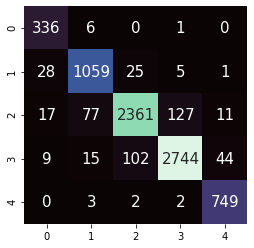

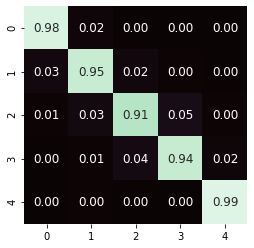

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_correct_sum_output 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.8306
	Weighted Accuracy: 	0.7926
	F1 Score: 		0.8306
	AUC_SCORE[CLS 0]: 	0.7854
	AUC_SCORE[CLS 1]: 	0.7566
	AUC_SCORE[CLS 2]: 	0.9466
	AUC_SCORE[CLS 3]: 	0.8800
	AUC_SCORE[CLS 4]: 	0.9137

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (13) and target (5) number of classes
  warnings.warn(*args, **kwargs)


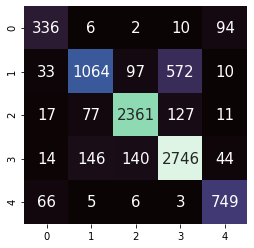

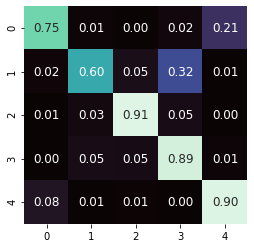

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_correct_sum_output 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.8440
	Drop Total Sample: 		656.0000
--------------------------------------------------------------------------------



In [6]:
evaluate_model(model, tokenizer, trainer, existing_company_only=True, dir_path='data/',batch_size=16, num_workers=4)

In [7]:
pretrained_bert_name = 'distilbert-base-cased'
incorrect_type = 'correct'
company_embedding_method = 'sum_output'
company_weight = 1
burn_in_epochs = 2
max_epochs = burn_in_epochs + 4
existing_company_only = True

model_name = '_'.join([pretrained_bert_name, incorrect_type, company_embedding_method, f'cpy_wt{company_weight}'])

#############################################################################################
model = FinSentiment(pretrained_bert_name, incorrect_type, company_embedding_method, company_weight, 
                     lr=5e-5, hidden_dropout_prob=0.1, discriminate=True, burn_in_epochs=burn_in_epochs)

logger = TensorBoardLogger('experiments/logs', name=model_name)
checkpoint_callback = ModelCheckpoint(
    filepath = 'experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name,
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_last=True,
    verbose=False
)
trainer = pl.Trainer(progress_bar_refresh_rate=20, gpus=1, max_epochs=max_epochs, logger=logger, callbacks=[checkpoint_callback], fast_dev_run=False)
trainer.fit(model, train_dataloader, val_dataloader)

trainer.save_checkpoint('experiments/saved_models/' + model_name + '/' + model_name + '_last.ckpt')

[PROGRESS] Saving hyperparameters
[PROGRESS] Initializing BERT model


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[PROGRESS] Initializing Company Embedding Layer
[PROGRESS] Initializing classifier
[PROGRESS] Done initialization



  | Name          | Type            | Params
--------------------------------------------------
0 | bert          | DistilBertModel | 65.2 M
1 | company_layer | Embedding       | 807 K 
2 | classifier    | Sequential      | 594 K 
3 | pooler        | BertPooler      | 590 K 
4 | dropout       | Dropout         | 0     


[PROGRESS] Burning in classifier epoch 0


[PROGRESS] Burning in classifier epoch 1


Saving latest checkpoint...


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (14) and target (5) number of classes
  warnings.warn(*args, **kwargs)


[MODEL NAME]: distilbert-base-cased_correct_sum_output 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9434
	Weighted Accuracy: 	0.9584
	F1 Score: 		0.9434
	AUC_SCORE[CLS 0]: 	0.9986
	AUC_SCORE[CLS 1]: 	0.9885
	AUC_SCORE[CLS 2]: 	0.9585
	AUC_SCORE[CLS 3]: 	0.9739
	AUC_SCORE[CLS 4]: 	0.9986

Confusion Matrix


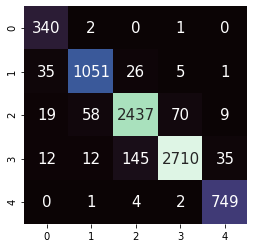

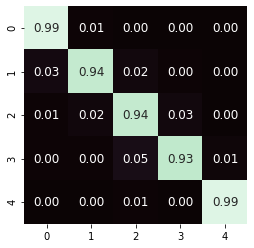

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_correct_sum_output 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.8355
	Weighted Accuracy: 	0.7972
	F1 Score: 		0.8355
	AUC_SCORE[CLS 0]: 	0.7827
	AUC_SCORE[CLS 1]: 	0.7523
	AUC_SCORE[CLS 2]: 	0.9521
	AUC_SCORE[CLS 3]: 	0.8796
	AUC_SCORE[CLS 4]: 	0.9172

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (14) and target (5) number of classes
  warnings.warn(*args, **kwargs)


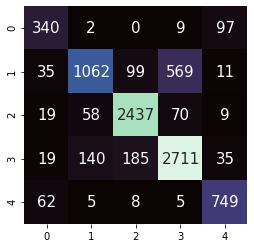

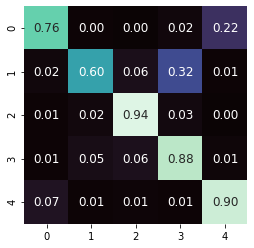

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_correct_sum_output 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.8429
	Drop Total Sample: 		603.0000
--------------------------------------------------------------------------------



In [8]:
evaluate_model(model, tokenizer, trainer, existing_company_only=True, dir_path='data/',batch_size=16, num_workers=4)

In [9]:
pretrained_bert_name = 'distilbert-base-cased'
incorrect_type = 'correct'
company_embedding_method = 'sum_output'
company_weight = 3
burn_in_epochs = 2
max_epochs = burn_in_epochs + 4
existing_company_only = True

model_name = '_'.join([pretrained_bert_name, incorrect_type, company_embedding_method, f'cpy_wt{company_weight}'])

#############################################################################################
model = FinSentiment(pretrained_bert_name, incorrect_type, company_embedding_method, company_weight, 
                     lr=5e-5, hidden_dropout_prob=0.1, discriminate=True, burn_in_epochs=burn_in_epochs)

logger = TensorBoardLogger('experiments/logs', name=model_name)
checkpoint_callback = ModelCheckpoint(
    filepath = 'experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name,
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_last=True,
    verbose=False
)
trainer = pl.Trainer(progress_bar_refresh_rate=20, gpus=1, max_epochs=max_epochs, logger=logger, callbacks=[checkpoint_callback], fast_dev_run=False)
trainer.fit(model, train_dataloader, val_dataloader)

trainer.save_checkpoint('experiments/saved_models/' + model_name + '/' + model_name + '_last.ckpt')

[PROGRESS] Saving hyperparameters
[PROGRESS] Initializing BERT model


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type            | Params
--------------------------------------------------
0 | bert          | DistilBertModel | 65.2 M
1 | company_layer | Embedding       | 807 K 
2 | classifier    | Sequential      | 594 K 
3 | pooler        | BertPooler      | 590 K 
4 | dropout       | Dropout         | 0     


[PROGRESS] Initializing Company Embedding Layer
[PROGRESS] Initializing classifier
[PROGRESS] Done initialization


[PROGRESS] Burning in classifier epoch 0


[PROGRESS] Burning in classifier epoch 1


Saving latest checkpoint...


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (11) and target (5) number of classes
  warnings.warn(*args, **kwargs)


[MODEL NAME]: distilbert-base-cased_correct_sum_output 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9399
	Weighted Accuracy: 	0.9503
	F1 Score: 		0.9399
	AUC_SCORE[CLS 0]: 	0.9980
	AUC_SCORE[CLS 1]: 	0.9908
	AUC_SCORE[CLS 2]: 	0.9486
	AUC_SCORE[CLS 3]: 	0.9760
	AUC_SCORE[CLS 4]: 	0.9984

Confusion Matrix


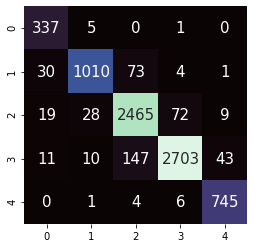

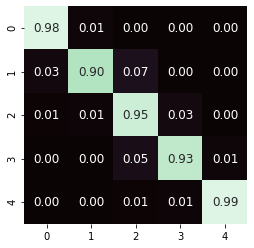

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_correct_sum_output 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.8314
	Weighted Accuracy: 	0.7892
	F1 Score: 		0.8314
	AUC_SCORE[CLS 0]: 	0.7832
	AUC_SCORE[CLS 1]: 	0.7693
	AUC_SCORE[CLS 2]: 	0.9431
	AUC_SCORE[CLS 3]: 	0.8822
	AUC_SCORE[CLS 4]: 	0.9123

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (11) and target (5) number of classes
  warnings.warn(*args, **kwargs)


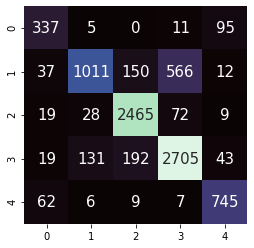

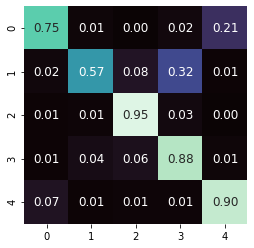

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_correct_sum_output 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.8437
	Drop Total Sample: 		643.0000
--------------------------------------------------------------------------------



In [10]:
evaluate_model(model, tokenizer, trainer, existing_company_only=True, dir_path='data/',batch_size=16, num_workers=4)

### Train on Inverse

In [11]:
pretrained_bert_name = 'distilbert-base-cased'
incorrect_type = 'inverse'
company_embedding_method = 'sum_output'
company_weight = 2
burn_in_epochs = 2
max_epochs = burn_in_epochs + 4
existing_company_only = True

model_name = '_'.join([pretrained_bert_name, incorrect_type, company_embedding_method, f'cpy_wt{company_weight}'])

#############################################################################################
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_bert_name)
(train_ids,X_train,y_train), (val_ids,X_val,y_val), (test_ids,X_test,y_test), _ = read_data(incorrect_type, dir_path='data/', existing_company_only=existing_company_only, sample=None)

X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])
train_ids = np.concatenate([train_ids, val_ids])

train_dataloader = tokenize_and_dataloader(X_train, y_train, tokenizer, train_ids, 16, 4, random=True)
val_dataloader = tokenize_and_dataloader(X_test, y_test, tokenizer, test_ids, 16, 4, random=False)

#############################################################################################
model = FinSentiment(pretrained_bert_name, incorrect_type, company_embedding_method, company_weight, 
                     lr=5e-5, hidden_dropout_prob=0.1, discriminate=True, burn_in_epochs=burn_in_epochs)

logger = TensorBoardLogger('experiments/logs', name=model_name)
checkpoint_callback = ModelCheckpoint(
    filepath = 'experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name,
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_last=True,
    verbose=False
)
trainer = pl.Trainer(progress_bar_refresh_rate=20, gpus=1, max_epochs=max_epochs, logger=logger, callbacks=[checkpoint_callback], fast_dev_run=False)
trainer.fit(model, train_dataloader, val_dataloader)

trainer.save_checkpoint('experiments/saved_models/' + model_name + '/' + model_name + '_last.ckpt')

[PROGRESS] Saving hyperparameters
[PROGRESS] Initializing BERT model


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[PROGRESS] Initializing Company Embedding Layer
[PROGRESS] Initializing classifier
[PROGRESS] Done initialization



  | Name          | Type            | Params
--------------------------------------------------
0 | bert          | DistilBertModel | 65.2 M
1 | company_layer | Embedding       | 807 K 
2 | classifier    | Sequential      | 594 K 
3 | pooler        | BertPooler      | 590 K 
4 | dropout       | Dropout         | 0     


[PROGRESS] Burning in classifier epoch 0


[PROGRESS] Burning in classifier epoch 1


Saving latest checkpoint...


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (9) and target (5) number of classes
  warnings.warn(*args, **kwargs)


[MODEL NAME]: distilbert-base-cased_inverse_sum_output 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9245
	Weighted Accuracy: 	0.9253
	F1 Score: 		0.9245
	AUC_SCORE[CLS 0]: 	0.9932
	AUC_SCORE[CLS 1]: 	0.9607
	AUC_SCORE[CLS 2]: 	0.9827
	AUC_SCORE[CLS 3]: 	0.9772
	AUC_SCORE[CLS 4]: 	0.9977

Confusion Matrix


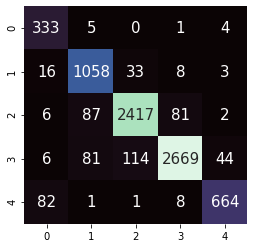

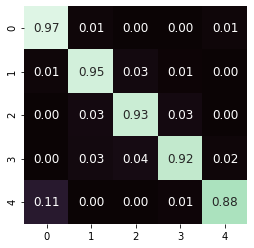

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_inverse_sum_output 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.8980
	Weighted Accuracy: 	0.9015
	F1 Score: 		0.8980
	AUC_SCORE[CLS 0]: 	0.9904
	AUC_SCORE[CLS 1]: 	0.9550
	AUC_SCORE[CLS 2]: 	0.9844
	AUC_SCORE[CLS 3]: 	0.9552
	AUC_SCORE[CLS 4]: 	0.9960

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (9) and target (5) number of classes
  warnings.warn(*args, **kwargs)


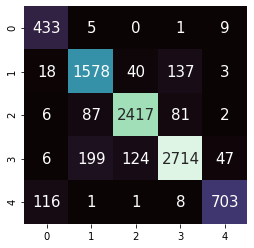

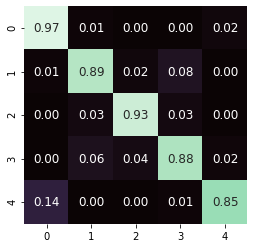

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_inverse_sum_output 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.9032
	Drop Total Sample: 		581.0000
--------------------------------------------------------------------------------



In [12]:
evaluate_model(model, tokenizer, trainer, existing_company_only=True, dir_path='data/',batch_size=16, num_workers=4)

In [13]:
pretrained_bert_name = 'distilbert-base-cased'
incorrect_type = 'inverse'
company_embedding_method = 'sum_output'
company_weight = 1
burn_in_epochs = 2
max_epochs = burn_in_epochs + 4
existing_company_only = True

model_name = '_'.join([pretrained_bert_name, incorrect_type, company_embedding_method, f'cpy_wt{company_weight}'])

#############################################################################################
model = FinSentiment(pretrained_bert_name, incorrect_type, company_embedding_method, company_weight, 
                     lr=5e-5, hidden_dropout_prob=0.1, discriminate=True, burn_in_epochs=burn_in_epochs)

logger = TensorBoardLogger('experiments/logs', name=model_name)
checkpoint_callback = ModelCheckpoint(
    filepath = 'experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name,
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_last=True,
    verbose=False
)
trainer = pl.Trainer(progress_bar_refresh_rate=20, gpus=1, max_epochs=max_epochs, logger=logger, callbacks=[checkpoint_callback], fast_dev_run=False)
trainer.fit(model, train_dataloader, val_dataloader)

trainer.save_checkpoint('experiments/saved_models/' + model_name + '/' + model_name + '_last.ckpt')

[PROGRESS] Saving hyperparameters
[PROGRESS] Initializing BERT model


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[PROGRESS] Initializing Company Embedding Layer
[PROGRESS] Initializing classifier
[PROGRESS] Done initialization



  | Name          | Type            | Params
--------------------------------------------------
0 | bert          | DistilBertModel | 65.2 M
1 | company_layer | Embedding       | 807 K 
2 | classifier    | Sequential      | 594 K 
3 | pooler        | BertPooler      | 590 K 
4 | dropout       | Dropout         | 0     


[PROGRESS] Burning in classifier epoch 0


[PROGRESS] Burning in classifier epoch 1


Saving latest checkpoint...


[MODEL NAME]: distilbert-base-cased_inverse_sum_output 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9335
	Weighted Accuracy: 	0.9477
	F1 Score: 		0.9335
	AUC_SCORE[CLS 0]: 	0.9965
	AUC_SCORE[CLS 1]: 	0.9606
	AUC_SCORE[CLS 2]: 	0.9797
	AUC_SCORE[CLS 3]: 	0.9637
	AUC_SCORE[CLS 4]: 	0.9986

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (10) and target (5) number of classes
  warnings.warn(*args, **kwargs)


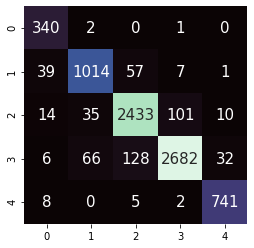

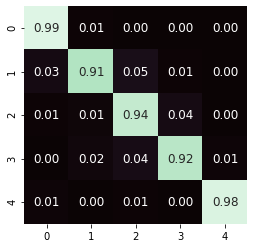

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_inverse_sum_output 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.9036
	Weighted Accuracy: 	0.9141
	F1 Score: 		0.9036
	AUC_SCORE[CLS 0]: 	0.9937
	AUC_SCORE[CLS 1]: 	0.9563
	AUC_SCORE[CLS 2]: 	0.9811
	AUC_SCORE[CLS 3]: 	0.9436
	AUC_SCORE[CLS 4]: 	0.9960

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (10) and target (5) number of classes
  warnings.warn(*args, **kwargs)


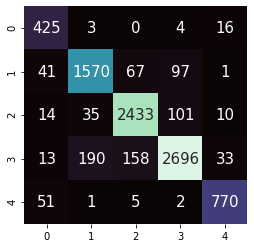

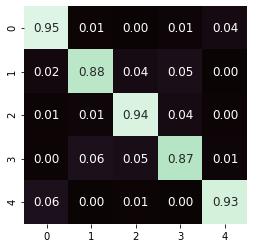

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_inverse_sum_output 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.9105
	Drop Total Sample: 		593.0000
--------------------------------------------------------------------------------



In [14]:
evaluate_model(model, tokenizer, trainer, existing_company_only=True, dir_path='data/',batch_size=16, num_workers=4)

In [15]:
pretrained_bert_name = 'distilbert-base-cased'
incorrect_type = 'inverse'
company_embedding_method = 'sum_output'
company_weight = 3
burn_in_epochs = 2
max_epochs = burn_in_epochs + 4
existing_company_only = True

model_name = '_'.join([pretrained_bert_name, incorrect_type, company_embedding_method, f'cpy_wt{company_weight}'])

#############################################################################################
model = FinSentiment(pretrained_bert_name, incorrect_type, company_embedding_method, company_weight, 
                     lr=5e-5, hidden_dropout_prob=0.1, discriminate=True, burn_in_epochs=burn_in_epochs)

logger = TensorBoardLogger('experiments/logs', name=model_name)
checkpoint_callback = ModelCheckpoint(
    filepath = 'experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name,
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_last=True,
    verbose=False
)
trainer = pl.Trainer(progress_bar_refresh_rate=20, gpus=1, max_epochs=max_epochs, logger=logger, callbacks=[checkpoint_callback], fast_dev_run=False)
trainer.fit(model, train_dataloader, val_dataloader)

trainer.save_checkpoint('experiments/saved_models/' + model_name + '/' + model_name + '_last.ckpt')

[PROGRESS] Saving hyperparameters
[PROGRESS] Initializing BERT model


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type            | Params
--------------------------------------------------
0 | bert          | DistilBertModel | 65.2 M
1 | company_layer | Embedding       | 807 K 
2 | classifier    | Sequential      | 594 K 
3 | pooler        | BertPooler      | 590 K 
4 | dropout       | Dropout         | 0     


[PROGRESS] Initializing Company Embedding Layer
[PROGRESS] Initializing classifier
[PROGRESS] Done initialization


[PROGRESS] Burning in classifier epoch 0


[PROGRESS] Burning in classifier epoch 1


Saving latest checkpoint...


[MODEL NAME]: distilbert-base-cased_inverse_sum_output 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9362
	Weighted Accuracy: 	0.9495
	F1 Score: 		0.9362
	AUC_SCORE[CLS 0]: 	0.9979
	AUC_SCORE[CLS 1]: 	0.9788
	AUC_SCORE[CLS 2]: 	0.9753
	AUC_SCORE[CLS 3]: 	0.9655
	AUC_SCORE[CLS 4]: 	0.9983

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (10) and target (5) number of classes
  warnings.warn(*args, **kwargs)


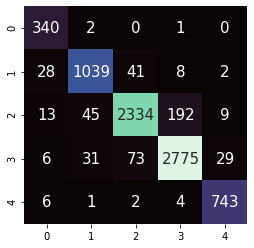

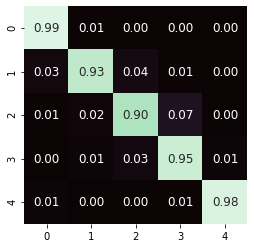

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_inverse_sum_output 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.9046
	Weighted Accuracy: 	0.9134
	F1 Score: 		0.9046
	AUC_SCORE[CLS 0]: 	0.9954
	AUC_SCORE[CLS 1]: 	0.9663
	AUC_SCORE[CLS 2]: 	0.9779
	AUC_SCORE[CLS 3]: 	0.9483
	AUC_SCORE[CLS 4]: 	0.9949

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (10) and target (5) number of classes
  warnings.warn(*args, **kwargs)


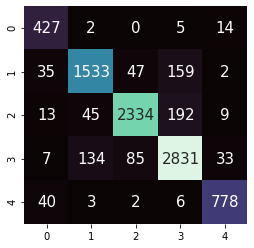

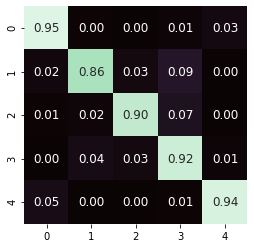

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_inverse_sum_output 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.9187
	Drop Total Sample: 		648.0000
--------------------------------------------------------------------------------



In [16]:
evaluate_model(model, tokenizer, trainer, existing_company_only=True, dir_path='data/',batch_size=16, num_workers=4)

### Train on Boundary

In [17]:
pretrained_bert_name = 'distilbert-base-cased'
incorrect_type = 'boundary'
company_embedding_method = 'sum_output'
company_weight = 2
burn_in_epochs = 2
max_epochs = burn_in_epochs + 4
existing_company_only = True

model_name = '_'.join([pretrained_bert_name, incorrect_type, company_embedding_method, f'cpy_wt{company_weight}'])

#############################################################################################
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_bert_name)
(train_ids,X_train,y_train), (val_ids,X_val,y_val), (test_ids,X_test,y_test), _ = read_data(incorrect_type, dir_path='data/', existing_company_only=existing_company_only, sample=None)

X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])
train_ids = np.concatenate([train_ids, val_ids])

train_dataloader = tokenize_and_dataloader(X_train, y_train, tokenizer, train_ids, 16, 4, random=True)
val_dataloader = tokenize_and_dataloader(X_test, y_test, tokenizer, test_ids, 16, 4, random=False)

#############################################################################################
model = FinSentiment(pretrained_bert_name, incorrect_type, company_embedding_method, company_weight, 
                     lr=5e-5, hidden_dropout_prob=0.1, discriminate=True, burn_in_epochs=burn_in_epochs)

logger = TensorBoardLogger('experiments/logs', name=model_name)
checkpoint_callback = ModelCheckpoint(
    filepath = 'experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name,
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_last=True,
    verbose=False
)
trainer = pl.Trainer(progress_bar_refresh_rate=20, gpus=1, max_epochs=max_epochs, logger=logger, callbacks=[checkpoint_callback], fast_dev_run=False)
trainer.fit(model, train_dataloader, val_dataloader)

trainer.save_checkpoint('experiments/saved_models/' + model_name + '/' + model_name + '_last.ckpt')

[PROGRESS] Saving hyperparameters
[PROGRESS] Initializing BERT model


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type            | Params
--------------------------------------------------
0 | bert          | DistilBertModel | 65.2 M
1 | company_layer | Embedding       | 807 K 
2 | classifier    | Sequential      | 594 K 
3 | pooler        | BertPooler      | 590 K 
4 | dropout       | Dropout         | 0     


[PROGRESS] Initializing Company Embedding Layer
[PROGRESS] Initializing classifier
[PROGRESS] Done initialization


[PROGRESS] Burning in classifier epoch 0


[PROGRESS] Burning in classifier epoch 1


Saving latest checkpoint...


[MODEL NAME]: distilbert-base-cased_boundary_sum_output 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9349
	Weighted Accuracy: 	0.9350
	F1 Score: 		0.9349
	AUC_SCORE[CLS 0]: 	0.9938
	AUC_SCORE[CLS 1]: 	0.9878
	AUC_SCORE[CLS 2]: 	0.9836
	AUC_SCORE[CLS 3]: 	0.9827
	AUC_SCORE[CLS 4]: 	0.9956

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (11) and target (5) number of classes
  warnings.warn(*args, **kwargs)


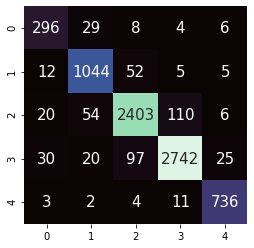

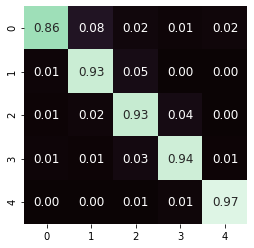

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_sum_output 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.8435
	Weighted Accuracy: 	0.8286
	F1 Score: 		0.8435
	AUC_SCORE[CLS 0]: 	0.9577
	AUC_SCORE[CLS 1]: 	0.9701
	AUC_SCORE[CLS 2]: 	0.9851
	AUC_SCORE[CLS 3]: 	0.9700
	AUC_SCORE[CLS 4]: 	0.9844

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (11) and target (5) number of classes
  warnings.warn(*args, **kwargs)


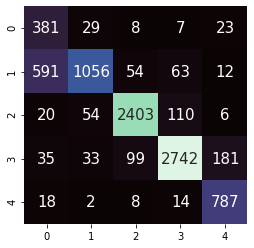

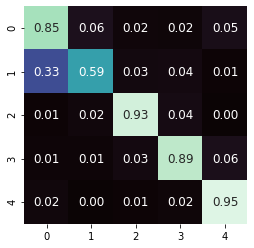

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_sum_output 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.9663
	Drop Total Sample: 		418.0000
--------------------------------------------------------------------------------



In [18]:
evaluate_model(model, tokenizer, trainer, existing_company_only=True, dir_path='data/',batch_size=16, num_workers=4)

In [19]:
pretrained_bert_name = 'distilbert-base-cased'
incorrect_type = 'boundary'
company_embedding_method = 'sum_output'
company_weight = 1
burn_in_epochs = 2
max_epochs = burn_in_epochs + 4
existing_company_only = True

model_name = '_'.join([pretrained_bert_name, incorrect_type, company_embedding_method, f'cpy_wt{company_weight}'])

#############################################################################################
model = FinSentiment(pretrained_bert_name, incorrect_type, company_embedding_method, company_weight, 
                     lr=5e-5, hidden_dropout_prob=0.1, discriminate=True, burn_in_epochs=burn_in_epochs)

logger = TensorBoardLogger('experiments/logs', name=model_name)
checkpoint_callback = ModelCheckpoint(
    filepath = 'experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name,
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_last=True,
    verbose=False
)
trainer = pl.Trainer(progress_bar_refresh_rate=20, gpus=1, max_epochs=max_epochs, logger=logger, callbacks=[checkpoint_callback], fast_dev_run=False)
trainer.fit(model, train_dataloader, val_dataloader)

trainer.save_checkpoint('experiments/saved_models/' + model_name + '/' + model_name + '_last.ckpt')

[PROGRESS] Saving hyperparameters
[PROGRESS] Initializing BERT model


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type            | Params
--------------------------------------------------
0 | bert          | DistilBertModel | 65.2 M
1 | company_layer | Embedding       | 807 K 
2 | classifier    | Sequential      | 594 K 
3 | pooler        | BertPooler      | 590 K 
4 | dropout       | Dropout         | 0     


[PROGRESS] Initializing Company Embedding Layer
[PROGRESS] Initializing classifier
[PROGRESS] Done initialization


[PROGRESS] Burning in classifier epoch 0


[PROGRESS] Burning in classifier epoch 1


Saving latest checkpoint...


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (13) and target (5) number of classes
  warnings.warn(*args, **kwargs)


[MODEL NAME]: distilbert-base-cased_boundary_sum_output 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9320
	Weighted Accuracy: 	0.9334
	F1 Score: 		0.9320
	AUC_SCORE[CLS 0]: 	0.9949
	AUC_SCORE[CLS 1]: 	0.9861
	AUC_SCORE[CLS 2]: 	0.9786
	AUC_SCORE[CLS 3]: 	0.9802
	AUC_SCORE[CLS 4]: 	0.9969

Confusion Matrix


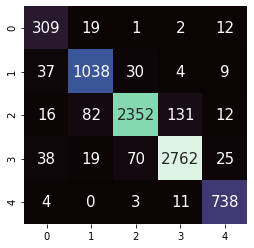

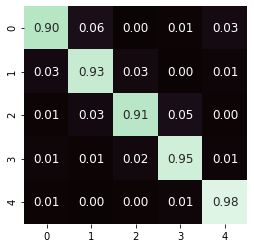

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_sum_output 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.8513
	Weighted Accuracy: 	0.8401
	F1 Score: 		0.8513
	AUC_SCORE[CLS 0]: 	0.9611
	AUC_SCORE[CLS 1]: 	0.9717
	AUC_SCORE[CLS 2]: 	0.9806
	AUC_SCORE[CLS 3]: 	0.9706
	AUC_SCORE[CLS 4]: 	0.9853

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (13) and target (5) number of classes
  warnings.warn(*args, **kwargs)


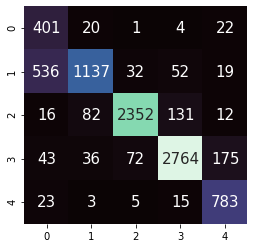

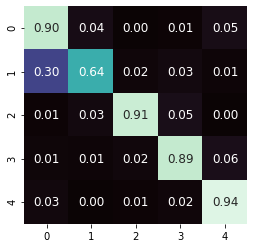

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_sum_output 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.9671
	Drop Total Sample: 		436.0000
--------------------------------------------------------------------------------



In [20]:
evaluate_model(model, tokenizer, trainer, existing_company_only=True, dir_path='data/',batch_size=16, num_workers=4)

In [21]:
pretrained_bert_name = 'distilbert-base-cased'
incorrect_type = 'boundary'
company_embedding_method = 'sum_output'
company_weight = 3
burn_in_epochs = 2
max_epochs = burn_in_epochs + 4
existing_company_only = True

model_name = '_'.join([pretrained_bert_name, incorrect_type, company_embedding_method, f'cpy_wt{company_weight}'])

#############################################################################################
model = FinSentiment(pretrained_bert_name, incorrect_type, company_embedding_method, company_weight, 
                     lr=5e-5, hidden_dropout_prob=0.1, discriminate=True, burn_in_epochs=burn_in_epochs)

logger = TensorBoardLogger('experiments/logs', name=model_name)
checkpoint_callback = ModelCheckpoint(
    filepath = 'experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name,
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_last=True,
    verbose=False
)
trainer = pl.Trainer(progress_bar_refresh_rate=20, gpus=1, max_epochs=max_epochs, logger=logger, callbacks=[checkpoint_callback], fast_dev_run=False)
trainer.fit(model, train_dataloader, val_dataloader)

trainer.save_checkpoint('experiments/saved_models/' + model_name + '/' + model_name + '_last.ckpt')

[PROGRESS] Saving hyperparameters
[PROGRESS] Initializing BERT model


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[PROGRESS] Initializing Company Embedding Layer
[PROGRESS] Initializing classifier
[PROGRESS] Done initialization



  | Name          | Type            | Params
--------------------------------------------------
0 | bert          | DistilBertModel | 65.2 M
1 | company_layer | Embedding       | 807 K 
2 | classifier    | Sequential      | 594 K 
3 | pooler        | BertPooler      | 590 K 
4 | dropout       | Dropout         | 0     


[PROGRESS] Burning in classifier epoch 0


[PROGRESS] Burning in classifier epoch 1


Saving latest checkpoint...


[MODEL NAME]: distilbert-base-cased_boundary_sum_output 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9360
	Weighted Accuracy: 	0.9369
	F1 Score: 		0.9360
	AUC_SCORE[CLS 0]: 	0.9952
	AUC_SCORE[CLS 1]: 	0.9885
	AUC_SCORE[CLS 2]: 	0.9669
	AUC_SCORE[CLS 3]: 	0.9846
	AUC_SCORE[CLS 4]: 	0.9965

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (10) and target (5) number of classes
  warnings.warn(*args, **kwargs)


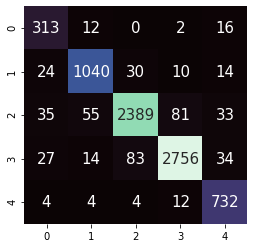

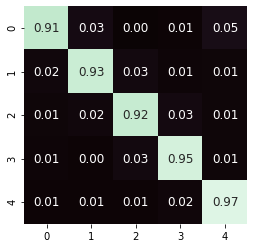

--------------------------------------------------------------------------------



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (10) and target (5) number of classes
  warnings.warn(*args, **kwargs)


[MODEL NAME]: distilbert-base-cased_boundary_sum_output 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.8413
	Weighted Accuracy: 	0.8249
	F1 Score: 		0.8413
	AUC_SCORE[CLS 0]: 	0.9659
	AUC_SCORE[CLS 1]: 	0.9717
	AUC_SCORE[CLS 2]: 	0.9704
	AUC_SCORE[CLS 3]: 	0.9729
	AUC_SCORE[CLS 4]: 	0.9884

Confusion Matrix


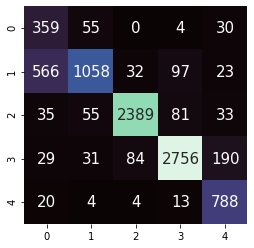

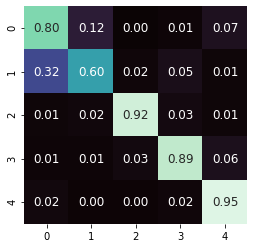

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_sum_output 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.9605
	Drop Total Sample: 		358.0000
--------------------------------------------------------------------------------



In [22]:
evaluate_model(model, tokenizer, trainer, existing_company_only=True, dir_path='data/',batch_size=16, num_workers=4)